# 3D Tabletop Task Generation:
In this notebook, we will show how to generate 3D tabletop ImageQA test cases in TaskVerse, including `WhatTask3DGridGenerator`, `WhatSizeTask3DGridGenerator`, `WhatDistanceTask3DGridGenerator`.

## Requirements

If you want to run this notebook, you need to add `..` to python package search path. You can do this by running the following command in the root directory of the repository:

In [1]:
import sys
sys.path.append("../..")

## Download TaskVerse source data from huggingface
The source metadata of TaskVerse is available at [Huggingface](https://huggingface.co/datasets/weikaih/Dynabench), you can download it by running the following command:

In [2]:
# from huggingface_hub import snapshot_download

# path = "../dynabench-source"
# snapshot_download(repo_id="weikaih/dynabench-source", repo_type="dataset", local_dir=path`WhatGridTask3DGenerator`, `WhereManyGridTask3DGenerator`, `HowManyGridTask3DGenerator`, `WhatAttributeGridTask3DGenerator`, `WhereAttributeGridTask3DGenerator`, and `HowManyAttributeGridTask3DGenerator`WhatGridTask3DGenerator`, `WhereManyGridTask3DGenerator`, `HowManyGridTask3DGenerator`, `WhatAttributeGridTask3DGenerator`, `WhereAttributeGridTask3DGenerator`, and `HowManyAttributeGridTask3DGenerator`.

## Using TaskGenerator to enumerate task plans and store them into local parquet file

* `TaskGenerator` is a class used to enumerate all the possible task plans from the source metadata, and generate VQA test cases based on the task plans. (e.g. `WhatGridTaskGenerator`)
* `TaskStore` is a class designed to handle the task plan generated by the task generator. The task store can output data in a pandas dataframe format.
  
In this notebook, instead of using a single type of generator, we will use multiple types of generators to generate test cases. So we introduce a new class `JointTaskGenerator`:
* `JointTaskGenerator` is a class to assemble multiple `TaskGenerator` into a joint task generator. 

After downloading the source data, we first create a `Objaverse3DMetaData` object to load the metadata from Objaverse. Then you can first create a dict of TaskGenerator, and then pass it to `JointTaskGenerator` to create a joint task generator. This generator has the same interface as a single task generator, but it will generate tasks from all the task generators in the dict.

In [2]:
from tma.imageqa.tabletop_3d import *
from tma.base import JointTaskGenerator
from tma.imageqa.metadata import Objaverse3DMetaData


blender_path = '/your_path/blender-4.0.1-linux-x64/blender'
assets_path = '/your_path/dynabench-source/3d_assets'
metadata = Objaverse3DMetaData('../../annotations', blender_path=blender_path, assets_path=assets_path)

generators = {
    'what'              : What3DGridTaskGenerator,
    'what size': WhatSize3DGridTaskGenerator,
    'what distance': WhatDistance3DGridTaskGenerator
}
generator = JointTaskGenerator(metadata, generators)

Once you feed the metadata to the task generator, we can start to enumerate all the possible task plans by using `generator.enumerate_task_plans()` method. We also need to initialize `TaskStore` to store the task plans. When we initialize `TaskStore` with a `output_file`, it will save the task plans to a local parquet file without holding them in memory. After task plans enumeration, use `task_store.close()` method to make sure the parquet writer is appropriately closed. 

Note that `buffer_size` is the maximum number of task plans to hold in memory before writing to the parquet file which save in disk. If your memory is limited, you can set a smaller buffer_size to avoid memory overflow. Typically, `1e6` is a good choice for server which has less than 32GB memory.


In [4]:
from tma.task_store import TaskStore

save_path = '../cache/3d_tabletop.parquet'  # path to save task plans to a parquet
task_store = TaskStore(output_file=save_path, schema=generator.schema, buffer_size=1e6)
generator.enumerate_task_plans(task_store)
task_store.close()

Writing to ../cache/3d_tabletop.parquet


enumerating [what] task: 100%|██████████| 465/465 [02:30<00:00,  3.10it/s]


Generated [58689137] what tasks


enumerating [what size] task: 100%|██████████| 465/465 [00:01<00:00, 268.27it/s]


Generated [19688] what size tasks


enumerating [what distance] task: 100%|██████████| 465/465 [02:52<00:00,  2.69it/s]


Generated [58657144] what distance tasks


The `JointTaskGenerator` also maintains a `stats` attribute, which is a dictionary that records the number of tasks generated by each task generator.

In [5]:
generator.stats

{'what': 58689137, 'what size': 19688, 'what distance': 58657144}

## Sample task plans from local parquet file and generate VQA test cases

We can Load the task plans from the local parquet file to a Pandas dataframe by using `pq.read_table(save_path, filters=f).to_pandas().astype(get_pd_schema(generator.schema)` method. After that, we can use `generator.generate()` method to generate VQA test cases based on the task plan.

  0%|          | 0/3 [00:00<?, ?it/s]

{'answer': 'vacuum cleaner',
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x7F989FB6BF70>,
 'image_metadata': {'H': 512,
                    'W': 512,
                    'blender_config': {'fill_light_horizontal_angle': -1.028051390944157,
                                       'fill_light_vertical_angle': -0.4115823077845404,
                                       'hdri_path': '/mnt/sdb1/dynabench-source/3d_assets/hdri/st_peters_square_night_4k.exr',
                                       'key_light_horizontal_angle': 0.31111053184221776,
                                       'key_light_vertical_angle': -0.6603312038205523,
                                       'plane_texture_path': '/mnt/sdb1/dynabench-source/3d_assets/plane_glbs/stone_tiles.glb',
                                       'sun_energy': 2.853990121162906,
                                       'sun_x': 0.10062021180954904,
                                       'sun_y': 0.35373228844321564

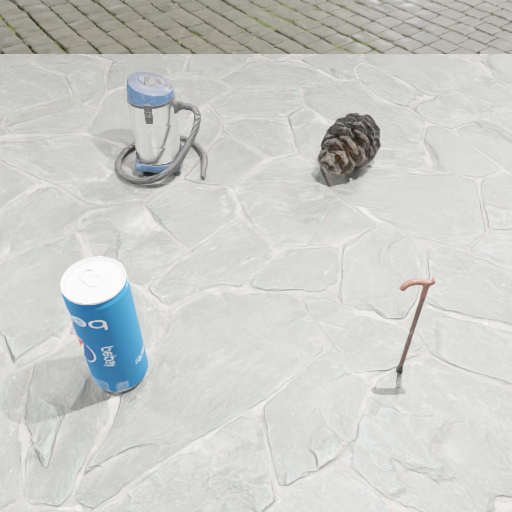

 33%|███▎      | 1/3 [00:34<01:09, 34.69s/it]

{'answer': 'vacuum cleaner',
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x7F989F99A1D0>,
 'image_metadata': {'H': 512,
                    'W': 512,
                    'blender_config': {'fill_light_horizontal_angle': -0.8791728494759601,
                                       'fill_light_vertical_angle': -0.23582152562881042,
                                       'hdri_path': '/mnt/sdb1/dynabench-source/3d_assets/hdri/evening_road_01_puresky_4k.exr',
                                       'key_light_horizontal_angle': 0.6603312038205523,
                                       'key_light_vertical_angle': -0.3288795290055154,
                                       'plane_texture_path': '/mnt/sdb1/dynabench-source/3d_assets/plane_glbs/dark_wood.glb',
                                       'sun_energy': 4.219325600403323,
                                       'sun_x': 0.2912240872236718,
                                       'sun_y': 0.7278795201427485},

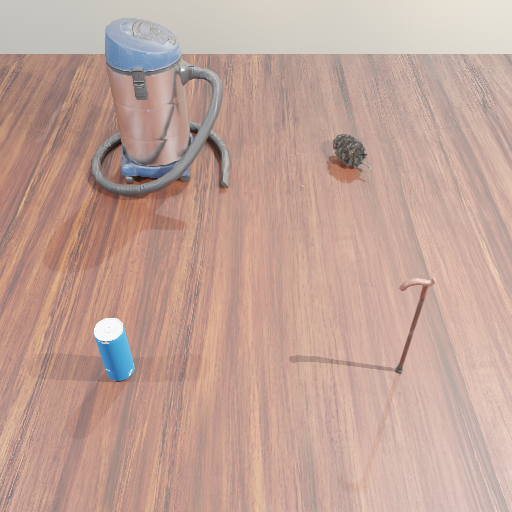

 67%|██████▋   | 2/3 [00:34<00:14, 14.36s/it]

{'answer': 'vacuum cleaner',
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x7F989F99ADD0>,
 'image_metadata': {'H': 512,
                    'W': 512,
                    'blender_config': {'fill_light_horizontal_angle': -0.8791728494759601,
                                       'fill_light_vertical_angle': -0.23582152562881042,
                                       'hdri_path': '/mnt/sdb1/dynabench-source/3d_assets/hdri/evening_road_01_puresky_4k.exr',
                                       'key_light_horizontal_angle': 0.6603312038205523,
                                       'key_light_vertical_angle': -0.3288795290055154,
                                       'plane_texture_path': '/mnt/sdb1/dynabench-source/3d_assets/plane_glbs/dark_wood.glb',
                                       'sun_energy': 4.219325600403323,
                                       'sun_x': 0.2912240872236718,
                                       'sun_y': 0.7278795201427485},

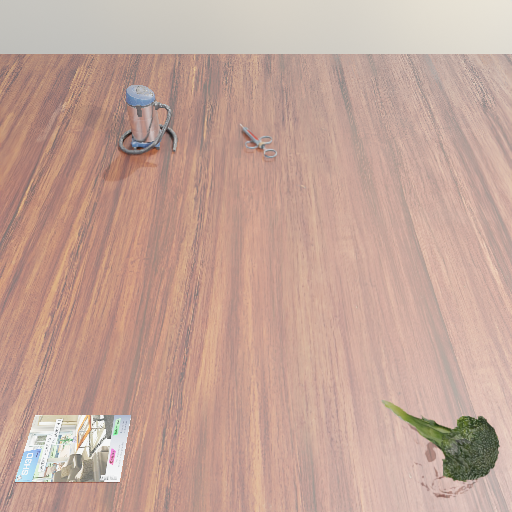

100%|██████████| 3/3 [00:57<00:00, 19.02s/it]


In [3]:
import pandas as pd
import pyarrow.parquet as pq
from tma.task_store import get_pd_schema
from tqdm import tqdm
from pprint import pprint # use pprint to print the task

types = ['what', 'what size', 'what distance'] # select the types of task plans you want
filters = [[('task type', '==', t)] for t in types]

pool = []
sample_num = 100
idx = 0
save_path = '../cache/3d_tabletop.parquet'

for filter in tqdm(filters):
    df = pq.read_table(save_path, filters=filter).to_pandas().astype(get_pd_schema(generator.schema))
    df.iloc[idx].dropna()
    task = generator.generate(df.iloc[idx].dropna().to_dict(), return_data=True)
    pprint(task)
    display(task['image'])

    if len(df) > sample_num:
        df = df.sample(sample_num)
    pool.append(df)

Above is 3 VQA test cases generated from different types of generators. 

The dataframe below is the example task plans we sampled from the parquet file:

The values start with "Q" in the `target category`, `reference category` columns of the returned dataframe is the QID of the category, which corresponds to a Wikidata entry (eg,  `Q11422` corresponds to https://www.wikidata.org/wiki/Q11422).

Note that different question types have different schema, For example, for "what" type question, we don't need count, so the `count` column is `<NA>`.

In [4]:
df = pd.concat(pool)
df

,task type,grid number,target category,absolute position,reference category,reference position,attribute type,attribute value,size,distance type
8340437,what,2,Q127956,back left,Q749316,left,<NA>,<NA>,<NA>,<NA>
52452157,what,3,Q758891,front middle,Q42622779,front right,material,metal,<NA>,<NA>
54405244,what,3,Q81944,back right,Q234668,right,color,gray,<NA>,<NA>
2445573,what,2,Q11035,front right,Q81895,front,material,plastic,<NA>,<NA>
14891334,what,2,Q148493,front right,Q127956,front,material,wood,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...
4592717,what distance,3,Q115618359,front middle,Q125356,front,color,brown,<NA>,closest
11290689,what distance,3,Q13276,back right,Q182780,back right,shape,triangle,<NA>,farthest
38822989,what distance,3,Q35473,back right,Q152,right,<NA>,<NA>,<NA>,closest
45215186,what distance,3,Q471898,back right,Q41274,back,color,black,<NA>,closest
